In [1]:
#pip install torch torchvision torchaudio

In [2]:
#pip -q install torchxrayvision

In [2]:
#%env CUDA_VISIBLE_DEVICES=2

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import time
from torchsummary import summary
import torchxrayvision as xrv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image

##Baixando dados

In [5]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset

fatal: destination path 'covid-chestxray-dataset' already exists and is not an empty directory.


In [6]:
data = xrv.datasets.COVID19_Dataset(imgpath="covid-chestxray-dataset/images/",csvpath="covid-chestxray-dataset/metadata.csv")

In [7]:
data

{'Aspergillosis': {np.float32(0.0): 534, np.float32(1.0): 1},
 'Aspiration': {np.float32(0.0): 534, np.float32(1.0): 1},
 'Bacterial': {np.float32(0.0): 487, np.float32(1.0): 48},
 'COVID-19': {np.float32(0.0): 193, np.float32(1.0): 342},
 'Chlamydophila': {np.float32(0.0): 534, np.float32(1.0): 1},
 'Fungal': {np.float32(0.0): 512, np.float32(1.0): 23},
 'H1N1': {np.float32(0.0): 534, np.float32(1.0): 1},
 'Herpes ': {np.float32(0.0): 532, np.float32(1.0): 3},
 'Influenza': {np.float32(0.0): 531, np.float32(1.0): 4},
 'Klebsiella': {np.float32(0.0): 526, np.float32(1.0): 9},
 'Legionella': {np.float32(0.0): 526, np.float32(1.0): 9},
 'Lipoid': {np.float32(0.0): 527, np.float32(1.0): 8},
 'MERS-CoV': {np.float32(0.0): 527, np.float32(1.0): 8},
 'MRSA': {np.float32(0.0): 534, np.float32(1.0): 1},
 'Mycoplasma': {np.float32(0.0): 530, np.float32(1.0): 5},
 'No Finding': {np.float32(0.0): 520, np.float32(1.0): 15},
 'Nocardia': {np.float32(0.0): 531, np.float32(1.0): 4},
 'Pneumocystis': 

COVID19_Dataset num_samples=535 views=['PA', 'AP'] data_aug=None

In [8]:
df = data.csv

In [9]:
labels = []
imgs = []

for i in range(len(data)):
    pd.Series(dict(zip(data.pathologies,data[i]["lab"])))
    labels.append(pd.Series(dict(zip(data.pathologies,data[i]["lab"]))))
    imgs.append(data[i]["img"])

labels = pd.DataFrame(labels)
imgs = [i[0] for i in imgs]

In [10]:
# prompt: encontrar casos onde todos os registros são 0

zeros = []
for index, row in labels.iterrows():
    if row.sum() == 0:
        zeros.append(index)
print(f"Indices where all records are zero: {zeros}")

Indices where all records are zero: []


In [11]:
labels = labels['COVID-19']

In [12]:
labels.value_counts()

COVID-19
1.0    342
0.0    193
Name: count, dtype: int64

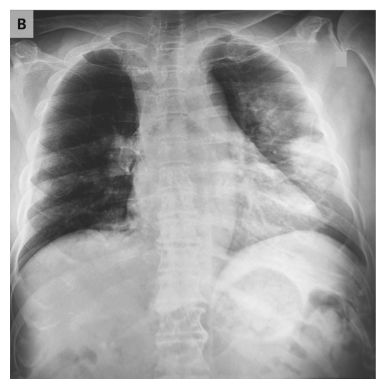

In [13]:
plt.imshow(imgs[1], cmap='gray')
plt.axis('off')
plt.show()

In [15]:
label_map = {
    0: 'Non-COVID',
    1: 'COVID-19'
}

In [16]:
base_dir = 'chestxray'
for split in ['train', 'val', 'test']:
    for label in label_map.values():
        os.makedirs(os.path.join(base_dir, split, label), exist_ok=True)

In [10]:
X_temp, X_test, y_temp, y_test = train_test_split(imgs, labels, test_size=0.15, stratify=labels, random_state=12)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.12, stratify=y_temp, random_state=33)

NameError: name 'train_test_split' is not defined

In [18]:
def save_images(img_list, label_list, split):
    for i, (img, label) in enumerate(zip(img_list, label_list)):
        folder = os.path.join(base_dir, split, label_map[label])

        # Se for numpy array float, converte para uint8 [0-255]
        if isinstance(img, np.ndarray):
            if img.dtype != np.uint8:
                img = (img * 255).astype(np.uint8)
            img = Image.fromarray(img)

        # Se for imagem PIL, mas em modo float, converte para RGB (ou L, dependendo do caso)
        elif img.mode == 'F':
            img = img.convert('RGB')  # ou 'L' para grayscale

        img.save(os.path.join(folder, f"{split}_{i}.png"))

In [19]:
save_images(X_train, y_train, 'train')
save_images(X_val, y_val, 'val')
save_images(X_test, y_test, 'test')

##Funções gerais

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
# Applying Transforms to the Data
# pre-trained models expect data with the same pre processing as data it was originally trained on
# thus those transformations are necessary
# + a bit of data augmentation
# podem resizes de tamanhos diferentes?
image_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3), #xrays are b&w but densenet expects rgb
        transforms.Resize(256),
        #transforms.RandomResizedCrop(size=332, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=5),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(), #image (format PIL) -> tensor (format pytorch)
        #normalizar por 255 - ToTensor já faz isso automatico
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    #val and test's transformations are deterministic (no noise, no diversity generated)
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [12]:
image_transforms_for_custom_networks = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(256),
        transforms.RandomRotation(degrees=5),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.488], [0.488])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.488], [0.488])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.488], [0.488])
    ])
}

In [13]:
# Load the Data

os.makedirs('chestxray/train/Non-COVID', exist_ok=True)
os.makedirs('chestxray/train/COVID-19', exist_ok=True)

os.makedirs('chestxray/val/Non-COVID', exist_ok=True)
os.makedirs('chestxray/val/COVID-19', exist_ok=True)

os.makedirs('chestxray/test/Non-COVID', exist_ok=True)
os.makedirs('chestxray/test/COVID-19', exist_ok=True)

# Set train and valid directory paths
dataset = 'chestxray'
train_directory = os.path.join(dataset, 'train') #chestxray/train
val_directory = os.path.join(dataset, 'val') #chestxray/val
test_directory = os.path.join(dataset, 'test') #chestxray/test

# mini batch size
bs = 16

#needed: #chestxray/train/covid
         #chestxray/train/noncovid
         #chestxray/val/covid
         #chestxray/val/noncovid
         #chestxray/test/covid
         #chestxray/test/noncovid

# Number of classes
num_classes = len(os.listdir(train_directory)) #num classes = num folds in each set fold

# Load Data from folders and apply transformations we set
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'val': datasets.ImageFolder(root=val_directory, transform=image_transforms['val']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
# ImageFolder creates mapping {class name: number}
# here the opposite is done: {number : class name} so we know the class outputted by its associated index
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
val_data_size = len(data['val'])
test_data_size = len(data['test'])
print(train_data_size, val_data_size, test_data_size)

# Create iterators for the Data loaded using DataLoader module
# batch generators
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True) #not learning sequences here
val_data_loader = DataLoader(data['val'], batch_size=bs, shuffle=False)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=False)

{0: 'COVID-19', 1: 'Non-COVID'}
399 55 81


In [14]:
#essas redes foram treinadas em imagens preto e branco, logo, 1 canal. até agora, estava usando transformacoes que expandiam nossas imagens p&b pra rgb
#(como descongelei a camada convolucional - no fine tuning - , então o número de canais precisa coincidir com o que foi treinado)
#ent preciso refazer essa parte do processamento, chamando a funcao que não expande o número de canais
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms_for_custom_networks['train']),
    'val': datasets.ImageFolder(root=val_directory, transform=image_transforms_for_custom_networks['val']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms_for_custom_networks['test'])
}

idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

train_data_size = len(data['train'])
val_data_size = len(data['val'])
test_data_size = len(data['test'])

train_data_loader_for_custom_networks = DataLoader(data['train'], batch_size=bs, shuffle=True) #not learning sequences here
val_data_loader_for_custom_networks = DataLoader(data['val'], batch_size=bs, shuffle=False)
test_data_loader_for_custom_networks = DataLoader(data['test'], batch_size=bs, shuffle=False)

{0: 'COVID-19', 1: 'Non-COVID'}


In [15]:
class EarlyStopping:
    #Stops the training if validation loss doesn't improve after a given patience
    def __init__(self, patience=5, verbose=True, delta=0.001, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.counter = 0 # how many epochs passed without getting better. counter < patience to keep going
        self.best_score = None # smallest loss
        self.early_stop = False # flag if training should be interrupted
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss  # minimize loss = maximize score

        if self.best_score is None: # save info of first model
            self.best_score = score
            self.save_checkpoint(val_loss, model)

        elif score < self.best_score + self.delta: #new epoch did not bring better results
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: # if patience's been hit
                self.early_stop = True # flag set to true

        else: #new epoch did bring better results - store
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [16]:
def train_and_validate(model, loss_criterion, optimizer, epochs, dataset="chestxraytry",
                       train_data_loader=train_data_loader, val_data_loader=val_data_loader, train_data_size=train_data_size,
                       val_data_size=val_data_size, device=device):

    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    #first: looping through training
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode -> activates dropout, batch norm, early stopping
        model.train()

        # Loss and Accuracy and Recall within the epoch
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0
        valid_true_positives = 0.0
        valid_false_negatives = 0.0

        #for each batch
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            # loss.item() returns average loss for the batch,
            # so we multiply by batch size to get an estimation of the sum for the batch
            #(so we can obtain the average loss over the whole dataset later)
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            # TODO sugiro usar metrics do sklearn 
            _, predictions = torch.max(outputs.data, 1) #returns index of most probable class for each instance - the actual predictions for each batch instance
            correct_counts = predictions.eq(labels.data.view_as(predictions)) #compares predictions with labels resulting in a bool tensor (1 if right, 0 if not)
            acc = torch.mean(correct_counts.type(torch.FloatTensor)) #convert correct_counts to float and then compute the mean (fraction of sucesses in the batch)
            train_acc += acc.item() * inputs.size(0) #multiply this mean by batch size to evaluate the total accuracy later
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))


        # Validation - no gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode -> dropout off, batch norm fixed
            model.eval()

            # for each validation batch -> similar logic
            for j, (inputs, labels) in enumerate(val_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                _, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * inputs.size(0)
                valid_true_positives += ((predictions == 1) & (labels == 1)).sum().item() #total of true positives
                valid_false_negatives += ((predictions == 0) & (labels == 1)).sum().item() #total of false negatives
                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

        # is this the best model based on tinniest validation loss?
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size
        avg_valid_loss = valid_loss/val_data_size
        avg_valid_acc = valid_acc/val_data_size
        valid_recall = valid_true_positives / (valid_true_positives + valid_false_negatives + 1e-7) #avoids 0 division
        #scheduler.step(avg_valid_loss)

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc, valid_recall])
        epoch_end = time.time()
        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Recall - {:.4f}, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, valid_recall, epoch_end-epoch_start))

        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_model_'+str(epoch)+'.pt')

    return model, history, best_epoch

In [40]:
def train_and_validate_for_custom_networks(model, loss_criterion, optimizer, epochs, dataset="chestxraytry",
                       train_data_loader=train_data_loader_for_custom_networks, val_data_loader=val_data_loader_for_custom_networks, train_data_size=train_data_size,
                       val_data_size=val_data_size, device=device):
    
    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    #first: looping through training
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode -> activates dropout, batch norm, early stopping
        model.train()

        # Loss and Accuracy and Recall within the epoch
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0
        valid_true_positives = 0.0
        valid_false_negatives = 0.0

        #for each batch
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            # loss.item() returns average loss for the batch,
            # so we multiply by batch size to get an estimation of the sum for the batch
            #(so we can obtain the average loss over the whole dataset later)
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            _, predictions = torch.max(outputs.data, 1) #returns index of most probable class for each instance - the actual predictions for each batch instance
            correct_counts = predictions.eq(labels.data.view_as(predictions)) #compares predictions with labels resulting in a bool tensor (1 if right, 0 if not)
            acc = torch.mean(correct_counts.type(torch.FloatTensor)) #convert correct_counts to float and then compute the mean (fraction of sucesses in the batch)
            train_acc += acc.item() * inputs.size(0) #multiply this mean by batch size to evaluate the total accuracy later
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))


        # Validation - no gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode -> dropout off, batch norm fixed
            model.eval()

            # for each validation batch -> similar logic
            for j, (inputs, labels) in enumerate(val_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                _, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * inputs.size(0)
                valid_true_positives += ((predictions == 1) & (labels == 1)).sum().item() #total of true positives
                valid_false_negatives += ((predictions == 0) & (labels == 1)).sum().item() #total of false negatives
                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

        # is this the best model based on tinniest validation loss?
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size
        avg_valid_loss = valid_loss/val_data_size
        avg_valid_acc = valid_acc/val_data_size
        valid_recall = valid_true_positives / (valid_true_positives + valid_false_negatives + 1e-7) #avoids 0 division
        #scheduler.step(avg_valid_loss)

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc, valid_recall])
        epoch_end = time.time()
        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Recall - {:.4f}, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, valid_recall, epoch_end-epoch_start))

        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_model_'+str(epoch)+'.pt')

    return model, history, best_epoch

In [20]:
def train_and_validate_earlystop(model, loss_criterion, optimizer, epochs, dataset="chestxraytry",
                       train_data_loader=train_data_loader, val_data_loader=val_data_loader, train_data_size=train_data_size,
                       val_data_size=val_data_size, device=device):

    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    early_stopping = EarlyStopping(patience=5, verbose=True, path=dataset+'_best_model.pt')

    #first: looping through training
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode -> activates dropout, batch norm, early stopping
        model.train()

        # Loss and Accuracy and Recall within the epoch
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0
        valid_true_positives = 0.0
        valid_false_negatives = 0.0

        #for each batch
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            # loss.item() returns average loss for the batch,
            # so we multiply by batch size to get an estimation of the sum for the batch
            #(so we can obtain the average loss over the whole dataset later)
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            _, predictions = torch.max(outputs.data, 1) #returns index of most probable class for each instance - the actual predictions for each batch instance
            correct_counts = predictions.eq(labels.data.view_as(predictions)) #compares predictions with labels resulting in a bool tensor (1 if right, 0 if not)
            acc = torch.mean(correct_counts.type(torch.FloatTensor)) #convert correct_counts to float and then compute the mean (fraction of sucesses in the batch)
            train_acc += acc.item() * inputs.size(0) #multiply this mean by batch size to evaluate the total accuracy later
            print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))


        # Validation - no gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode -> dropout off, batch norm fixed
            model.eval()

            # for each validation batch -> similar logic
            for j, (inputs, labels) in enumerate(val_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                _, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * inputs.size(0)
                valid_true_positives += ((predictions == 1) & (labels == 1)).sum().item() #total of true positives
                valid_false_negatives += ((predictions == 0) & (labels == 1)).sum().item() #total of false negatives
                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size
        avg_valid_loss = valid_loss/val_data_size
        avg_valid_acc = valid_acc/val_data_size
        valid_recall = valid_true_positives / (valid_true_positives + valid_false_negatives + 1e-7) #avoids 0 division

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc, valid_recall])
        epoch_end = time.time()
        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Recall - {:.4f}, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, valid_recall, epoch_end-epoch_start))

        early_stopping(avg_valid_loss, model)
        if early_stopping.early_stop:
          print("Training interrupted")
          break

        # Save if the model has best accuracy till now
        model.load_state_dict(torch.load(dataset+'_model_'+str(epoch)+'pt'))

    return model, history, best_epoch

In [21]:
def computeTestSetPerformance(model, loss_criterion, device):
    # Function to compute the accuracy on the test set

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0
    test_true_positives = 0.0
    test_false_negatives = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # for each batch in test
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            test_acc += acc.item() * inputs.size(0)
            test_true_positives += ((predictions == 1) & (labels == 1)).sum().item()
            test_false_negatives += ((predictions == 0) & (labels == 1)).sum().item()

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy and recall
    avg_test_loss = test_loss/test_data_size
    avg_test_acc = test_acc/test_data_size
    test_recall = test_true_positives / (test_true_positives + test_false_negatives + 1e-7)

    print("Test accuracy : " + str(avg_test_acc))


In [22]:
def predict(model, test_image_name):
    #Function to predict the class of a single test image

    transform = image_transforms['test'] #loads pre processing needed into test images in 'transform' object
    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    test_image_tensor = transform(test_image) #applies the processing

    if torch.cuda.is_available():
      #view regorganized tensor so its format is (batch size X number of channels X height X depth)
        #test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
        #unsqueeze(dim) adds dimension of size 1 at position dim
        test_image_tensor = test_image_tensor.unsqueeze(0).cuda()
    else:
        #test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
        test_image_tensor = test_image_tensor.unsqueeze(0)

    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor) #model outputs (probabilities for each class)
        #ps = torch.exp(out) #for LogSoftMax activation

        topk, topclass = out.topk(1, dim=1) #most likely class
        cls = idx_to_class[topclass.cpu().numpy()[0][0]]
        score = topk.cpu().numpy()[0][0]
        print("Prediction:", cls, ", with probability:", score) #shows most likely class

###CheXNet

https://arxiv.org/pdf/1711.05225

https://github.com/arnoweng/CheXNet/blob/master/model.py

In [39]:
!git clone https://github.com/arnoweng/CheXNet.git

fatal: destination path 'CheXNet' already exists and is not an empty directory.


In [40]:
!cd CheXNet

In [41]:
#carregar Densenet 121, carregar pesos pré-treinados de model.pth.tar, freeze camadas convolucionais e alterar e retreinar ultima camada (fully connected)

In [42]:
print(os.listdir("/Users/llbm/Desktop/deep_learning/trabalho/CheXNet"))

['__pycache__', 'model.py', 'README.md', 'read_data.py', '.gitattributes', 'model.pth.tar', '.git', 'localization', 'ChestX-ray14']


In [43]:
import importlib.util
import sys

model_path = "/Users/llbm/Desktop/deep_learning/trabalho/CheXNet/model.py"
model_dir = os.path.dirname(model_path)

if model_dir not in sys.path:
    sys.path.append(model_dir)

spec = importlib.util.spec_from_file_location("chexnet_model", model_path)
chexnet_model = importlib.util.module_from_spec(spec)
sys.modules["chexnet_model"] = chexnet_model
spec.loader.exec_module(chexnet_model)

model = chexnet_model.DenseNet121(out_size = 14)

In [44]:
checkpoint = torch.load("/Users/llbm/Desktop/deep_learning/trabalho/CheXNet/model.pth.tar", map_location=device)
state_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint

In [45]:
from collections import OrderedDict
import re

def clean_state_dict_keep_densenet121(state_dict):
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k
        # Remove só o prefixo 'module.' — mantém o 'densenet121.'
        if name.startswith("module."):
            name = name[len("module."):]

        # Corrige norm.X para normX (sem ponto)
        name = re.sub(r'norm\.(\d+)', r'norm\1', name)
        # Se tiver conv.X, corrige para convX (sem ponto)
        name = re.sub(r'conv\.(\d+)', r'conv\1', name)

        new_state_dict[name] = v
    return new_state_dict

checkpoint = torch.load("model.pth.tar", map_location=device)
state_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint

cleaned_state_dict = clean_state_dict_keep_densenet121(state_dict)

In [46]:
model.load_state_dict(cleaned_state_dict)

<All keys matched successfully>

In [47]:
#only retrain the last, fully connected layer
for param in model.parameters():
    param.requires_grad = False

In [48]:
#print([name for name, _ in model.named_modules()])

In [49]:
#print(model.densenet121.classifier)

In [50]:
fc_inputs = model.densenet121.classifier[0].in_features
model.densenet121.classifier[0] = nn.Linear(fc_inputs, 2)

In [51]:
for param in model.densenet121.classifier[0].parameters():
    param.requires_grad = True
model = model.to(device)

In [52]:
# Define optimizer and loss function
loss_func = nn.CrossEntropyLoss()
params_to_be_optim = [p for p in model.parameters() if p.requires_grad]
#depois tentar fine tuning melhor
print(len(params_to_be_optim))
optimizer = optim.Adam(params_to_be_optim, lr=0.001)

2


In [53]:
num_epochs = 200
trained_model, history, best_epoch = train_and_validate(model, loss_func, optimizer, num_epochs)
torch.save(history, '_chexnet_history.pt') #chestxray_chexnet_history.pt

Epoch: 1/200
Batch number: 000, Training: Loss: 0.7012, Accuracy: 0.4375
Batch number: 001, Training: Loss: 0.6898, Accuracy: 0.5000
Batch number: 002, Training: Loss: 0.7090, Accuracy: 0.3125
Batch number: 003, Training: Loss: 0.6876, Accuracy: 0.5625
Batch number: 004, Training: Loss: 0.7008, Accuracy: 0.5000
Batch number: 005, Training: Loss: 0.6771, Accuracy: 0.7500
Batch number: 006, Training: Loss: 0.6868, Accuracy: 0.5625
Batch number: 007, Training: Loss: 0.6995, Accuracy: 0.5625
Batch number: 008, Training: Loss: 0.6512, Accuracy: 0.7500
Batch number: 009, Training: Loss: 0.6179, Accuracy: 0.8750
Batch number: 010, Training: Loss: 0.6333, Accuracy: 0.7500
Batch number: 011, Training: Loss: 0.5735, Accuracy: 0.8125
Batch number: 012, Training: Loss: 0.6972, Accuracy: 0.5625
Batch number: 013, Training: Loss: 0.7897, Accuracy: 0.3750
Batch number: 014, Training: Loss: 0.6745, Accuracy: 0.6250
Batch number: 015, Training: Loss: 0.6590, Accuracy: 0.6250
Batch number: 016, Training

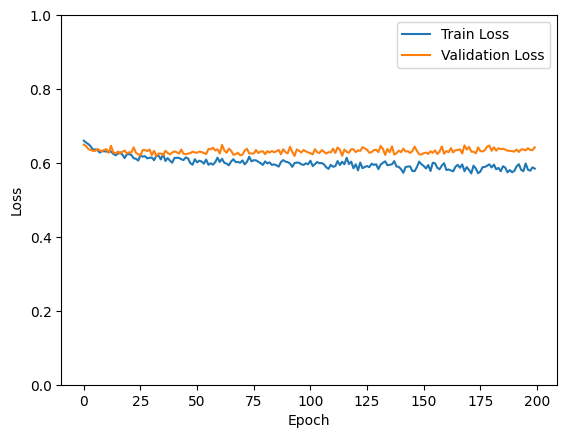

In [54]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.show()

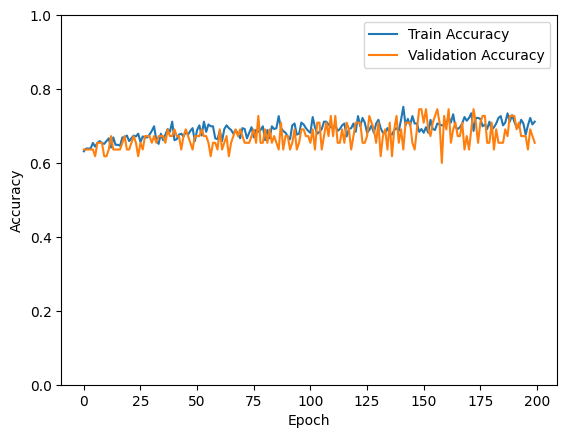

In [55]:
plt.plot(history[:,2:4])
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

###torchxrayvision

####transfer learning tradicional (só fc)

https://mlmed.org/torchxrayvision/

In [31]:
images, labels = next(iter(train_data_loader_for_custom_networks))
print(images.shape)

torch.Size([16, 1, 224, 224])


In [59]:
#modelo DenseNet121 com os pesos do CheXpert
model = xrv.models.DenseNet(weights="densenet121-res224-chex")

In [60]:
for name, param in model.named_parameters():
    print(name)
    break

features.conv0.weight


In [61]:
#congela todos os pesos, dai altera a fully connected e descongela só ela
for param in model.parameters():
    param.requires_grad = False

n_features = model.classifier.in_features
model.classifier = nn.Linear(n_features, 2) # 2 saidas: COVID / não-COVID | CheXpert tem 18


for param in model.classifier.parameters():
    param.requires_grad = True

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(),lr=0.001)

In [32]:
class DenseNetWrapper(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, x):
        if x.shape[1] == 3:
        # Converte de 3 canais pra 1 canal - ta forcando isso, gambiarra pq eu nao achei o problema k)
            x = x.mean(dim=1, keepdim=True)
        features = self.base_model.features(x)  # saída 4D: [batch, canais, H, W]
        features = nn.functional.adaptive_avg_pool2d(features, (1, 1))  # reduz para [batch, canais, 1, 1]
        features = torch.flatten(features, 1)  # achata para [batch, canais]
        out = self.base_model.classifier(features)  # passa na camada linear
        return out

In [33]:
model = DenseNetWrapper(model)
model = model.to(device)

In [66]:
num_epochs = 100
trained_model, history, best_epoch = train_and_validate_for_custom_networks(model, loss_func, optimizer, num_epochs)
torch.save(history, '_torchvisiontransferlearning_history.pt')

Epoch: 1/100
Batch number: 000, Training: Loss: 0.7717, Accuracy: 0.1875
Batch number: 001, Training: Loss: 0.7375, Accuracy: 0.5000
Batch number: 002, Training: Loss: 0.6749, Accuracy: 0.6250
Batch number: 003, Training: Loss: 0.9243, Accuracy: 0.3750
Batch number: 004, Training: Loss: 0.7574, Accuracy: 0.5000
Batch number: 005, Training: Loss: 0.7631, Accuracy: 0.4375
Batch number: 006, Training: Loss: 0.6628, Accuracy: 0.8125
Batch number: 007, Training: Loss: 0.7011, Accuracy: 0.3750
Batch number: 008, Training: Loss: 0.6822, Accuracy: 0.6250
Batch number: 009, Training: Loss: 0.6713, Accuracy: 0.5625
Batch number: 010, Training: Loss: 0.6815, Accuracy: 0.5625
Batch number: 011, Training: Loss: 0.5975, Accuracy: 0.7500
Batch number: 012, Training: Loss: 0.5352, Accuracy: 0.8125
Batch number: 013, Training: Loss: 0.7165, Accuracy: 0.6250
Batch number: 014, Training: Loss: 0.4325, Accuracy: 0.8750
Batch number: 015, Training: Loss: 0.6540, Accuracy: 0.6875
Batch number: 016, Training

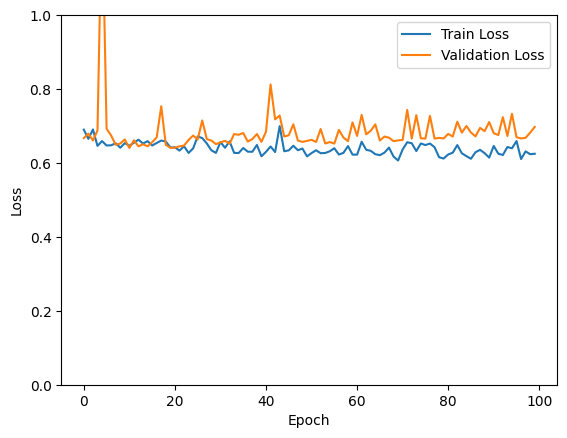

In [67]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.show()

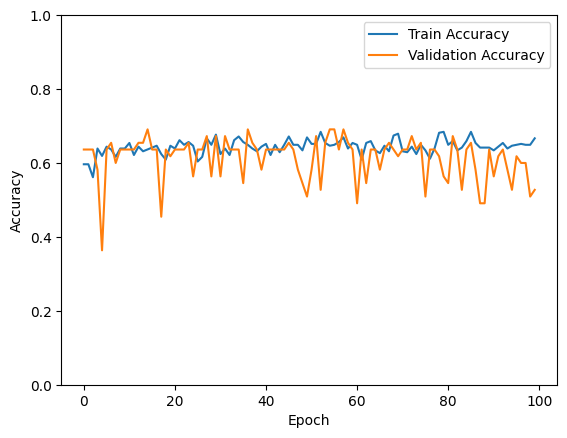

In [68]:
plt.plot(history[:,2:4])
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

####fine tuning (ultima conv + fc)

In [34]:
model = xrv.models.DenseNet(weights="densenet121-res224-chex")

In [35]:
print(model)

XRV-DenseNet121-densenet121-res224-chex


In [36]:
in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(in_features, 2),
    nn.Sigmoid()
)

In [72]:
# for name, param in model.named_parameters():
#     print(name, param.requires_grad)

In [37]:
#freeze todos os parametros
for param in model.parameters():
    param.requires_grad = False
#menos os ultimos
for name, param in model.named_parameters():
    if "features.denseblock4" in name or "features.norm5" in name or "classifier" in name:
        param.requires_grad = True

In [38]:
params_to_update = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params_to_update, lr=1e-4)
loss_fn = nn.BCELoss()

In [39]:
model = DenseNetWrapper(model)
model = model.to(device)

In [1]:
num_epochs = 12
trained_model, history, best_epoch = train_and_validate_for_custom_networks(model, loss_fn, optimizer, num_epochs)
torch.save(history, '_torchvisionfinetuning_history.pt')

NameError: name 'train_and_validate_for_custom_networks' is not defined

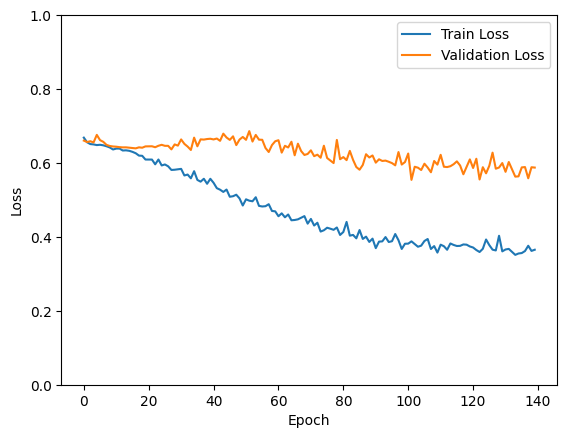

In [82]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.show()

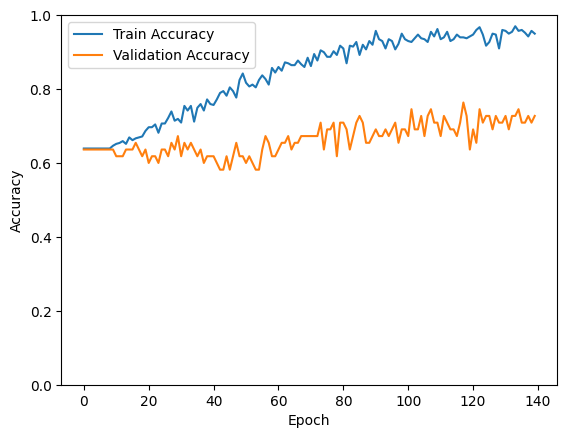

In [83]:
plt.plot(history[:,2:4])
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()